<a href="https://colab.research.google.com/github/Fadiabdf/OPT/blob/main/TP4/TP4_OPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tsplib95
!pip install springpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 20.9 MB/s eta 0:00:00
  Attempting uninstall: tabulate
    Found existing installation: tabulate 0.9.0
    Uninstalling tabulate-0.9.0:
      Successfully uninstalled tabulate-0.9.0
  Attempting uninstall: networkx
    Found existing installation: networkx 3.4.2
    Uninstalling networkx-3.4.2:
      Successfully uninstalled networkx-3.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nx-cugraph-cu12 25.2.0 requires networkx>=3.2, but you have networkx 2.8.8 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-c

In [ ]:
import numpy as np
import xml.etree.ElementTree as ET
import time
from math import ceil
import tsplib95
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx

Charger un fichier XML, extrait les villes et leurs distances, construit un graphe pondéré, puis affiche le nombre total de villes

In [ ]:
# Charger et parser le fichier XML
instance = 'berlin52.xml'  # Remplace par ton fichier XML
problem = ET.parse(instance)

root = problem.getroot()  # Récupérer la racine du fichier XML

# Initialiser le graphe
graphe = {}

# Extraire les sommets et leurs distances
for i, sommet in enumerate(root.find('graph').findall('vertex')):
    aretes = {}
    for arete in sommet.findall('edge'):
        cible = int(arete.text)  # ID de la ville cible
        cout = float(arete.get('cost'))  # Distance
        aretes[cible] = cout
    graphe[i] = aretes

nombre_sommets = len(graphe)
print(f"Nombre total de villes : {nombre_sommets}")


Nombre total de villes : 52


Initialiser une matrice de distances avec des valeurs infinies, puis la remplit à partir des données du graphe. La diagonale est mise à zéro pour représenter la distance nulle entre une ville et elle-même. Ensuite, un sous-ensemble de la matrice est extrait pour des tests

In [ ]:
# Initialiser une matrice de distances avec des valeurs infinies
matrice_distances = np.full((nombre_sommets, nombre_sommets), np.inf)
matrice_distances = matrice_distances.astype(int)  # Convertit en entiers

# Remplir la matrice de distances avec les coûts extraits
for i, aretes in graphe.items():
    for j, cout in aretes.items():
        matrice_distances[i, j] = cout

# Définir la diagonale à zéro (distance d'un sommet à lui-même)
np.fill_diagonal(matrice_distances, 0)

# Sélectionner un sous-ensemble de la matrice pour les tests
#------------------------------------------------------------------------
n_sous_ensemble = 15  # Nombre de sommets à inclure dans le sous-ensemble
print(f"Nombre de nœuds à prendre pour le test : {n_sous_ensemble}")
sous_ensemble_matrice = matrice_distances[:n_sous_ensemble, :n_sous_ensemble]
#------------------------------------------------------------------------

# Convertir la matrice en liste pour une utilisation ultérieure
matrice_distances_liste = matrice_distances.tolist()
sous_ensemble_matrice_liste = sous_ensemble_matrice.tolist()

# Afficher le sous-ensemble de la matrice
print(sous_ensemble_matrice)

Nombre de nœuds à prendre pour le test : 15
[[   0  666  281  395  291  326  640  426  600  561 1040  655  975 1120
   299]
 [ 666    0  649 1047  945  978   45  956 1134 1132 1638 1258 1440 1515
   957]
 [ 281  649    0  603  508  542  610  308  485  487 1266  891 1247 1399
   504]
 [ 395 1047  603    0  104   69 1026  525  611  533  663  294  711  897
   100]
 [ 291  945  508  104    0   35  923  470  583  513  760  382  769  944
    25]
 [ 326  978  542   69   35    0  957  491  596  523  726  349  744  922
    40]
 [ 640   45  610 1026  923  957    0  918 1095 1095 1627 1245 1440 1521
   935]
 [ 426  956  308  525  470  491  918    0  183  180 1144  812 1234 1414
   452]
 [ 600 1134  485  611  583  596 1095  183    0   83 1165  873 1316 1507
   561]
 [ 561 1132  487  533  513  523 1095  180   83    0 1082  792 1236 1428
   490]
 [1040 1638 1266  663  760  726 1627 1144 1165 1082    0  387  442  619
   762]
 [ 655 1258  891  294  382  349 1245  812  873  792  387    0  452  653
   3

<ipython-input-5-5e13ddbb3846>:3: RuntimeWarning: invalid value encountered in cast
  matrice_distances = matrice_distances.astype(int)  # Convertit en entiers


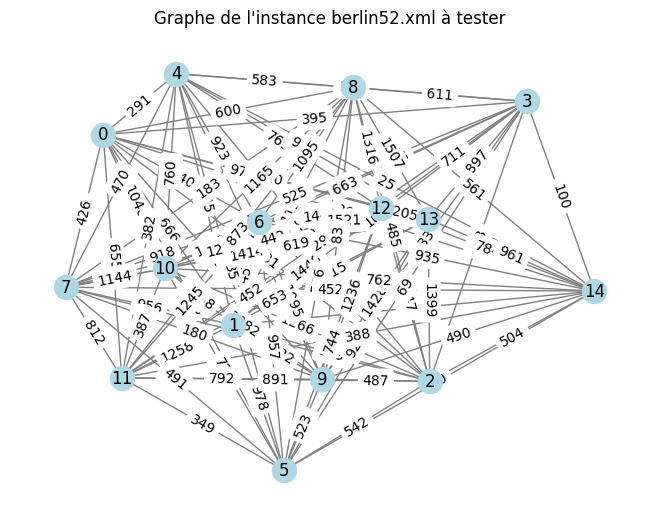

In [ ]:
import networkx as nx

# Créer un graphe à partir de la matrice de distances
G = nx.Graph()
for i in range(len(sous_ensemble_matrice_liste)):
    for j in range(len(sous_ensemble_matrice_liste[i])):
        if i != j:
            G.add_edge(i, j, weight= sous_ensemble_matrice_liste[i][j])

# Dessiner le graphe
pos = nx.spring_layout(G)  # Positionnement des nœuds
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title("Graphe de l'instance " +instance+ " à tester")
plt.show()

### ACO (Ant Colony Optimization) — Optimisation par Colonies de **Fourmis**

ACO est une métaheuristique inspirée du comportement des colonies de fourmis qui trouvent le plus court chemin entre leur nid et une source de nourriture.
Elles déposent une substance chimique appelée phéromone sur leur chemin : plus le chemin est court et utilisé, plus il est renforcé par les phéromones, incitant d'autres fourmis à l'emprunter.

# Algorithme de base :
À chaque itération, un certain nombre de fourmis (agents) construisent des tournées (solutions) probabilistes :

1.   Chaque fourmi commence dans une ville aléatoire.
2.   Elle construit sa tournée ville par ville, en choisissant la prochaine ville avec une probabilité basée sur deux facteurs :
 *   Phéromone : trace laissée par les autres fourmis
 *   Attractivité heuristique : inverse de la distance (plus c'est court, mieux c'est)
3.   Une fois toutes les tournées terminées :
 *   Les phéromones s’évaporent (diminuent)
 *   Les meilleures tournées renforcent les chemins qu’elles ont empruntés (ajout de phéromones)


# **Paramètres et leur rôle :**
- n_fourmis : Nombre de fourmis par itération. Plus il y en a, plus on explore.
- n_iterations : Nombre d’itérations (ou générations). Plus il est élevé, plus l’algorithme a de chances de converger vers une bonne solution.
- alpha : Influence des phéromones. Si élevé, les fourmis sont attirées par les chemins déjà marqués.
- beta : Influence de l’attractivité heuristique (1/distance). Si élevé, les fourmis préfèrent les chemins plus courts.
- Q : Quantité de phéromone déposée par une fourmi. Plus c’est grand, plus les bonnes solutions influencent les autres.
- pheromones : Matrice qui garde les niveaux de phéromone entre chaque paire de villes. Mise à jour après chaque itération.
- rho : Taux d’évaporation des phéromones (entre 0 et 1). Un rho élevé fait disparaître vite les anciennes traces, favorisant l’exploration.

In [ ]:
import random
import numpy as np

def aco_tsp(distances, n_fourmis=20, n_iterations=100, alpha=1, beta=5, rho=0.5, Q=100):
    # Nombre de villes dans le TSP
    n_villes = len(distances)
    distances = np.array(distances)

    # Initialisation de la matrice des phéromones : 1 partout au début
    pheromones = np.ones((n_villes, n_villes))

    # Variables pour stocker la meilleure tournée et sa distance
    meilleure_distance = float('inf')
    meilleure_tournee = []

    # Boucle principale sur les itérations
    for iteration in range(n_iterations):
        toutes_les_tournees = []
        toutes_les_distances = []

        # Chaque fourmi construit une tournée
        for _ in range(n_fourmis):
            non_visitees = list(range(n_villes))  # Villes restantes à visiter
            tournee = []

            # Choisir une ville de départ aléatoirement
            ville_courante = random.choice(non_visitees)
            tournee.append(ville_courante)
            non_visitees.remove(ville_courante)

            # Construire la tournée complète
            while non_visitees:
                proba = []

                # Calculer la probabilité de transition vers chaque ville non visitée
                for ville in non_visitees:
                    tau = pheromones[ville_courante][ville] ** alpha   # Influence des phéromones
                    eta = (1 / distances[ville_courante][ville]) ** beta if distances[ville_courante][ville] != 0 else 0  # Attractivité
                    proba.append(tau * eta)

                # Normalisation des probabilités
                somme = sum(proba)
                proba = [p / somme for p in proba]

                # Sélection probabiliste de la prochaine ville
                prochaine_ville = random.choices(non_visitees, weights=proba, k=1)[0]
                tournee.append(prochaine_ville)
                non_visitees.remove(prochaine_ville)
                ville_courante = prochaine_ville

            # Calcul de la distance totale de la tournée (avec retour à la ville de départ)
            distance_totale = sum(distances[tournee[i]][tournee[(i+1)%n_villes]] for i in range(n_villes))

            # Sauvegarder la tournée et sa distance
            toutes_les_tournees.append(tournee)
            toutes_les_distances.append(distance_totale)

            # Mise à jour de la meilleure solution si nécessaire
            if distance_totale < meilleure_distance:
                meilleure_distance = distance_totale
                meilleure_tournee = tournee

        # Évaporation des phéromones
        pheromones *= (1 - rho)

        # Mise à jour des phéromones avec les nouvelles tournées
        for i in range(n_fourmis):
            tour = toutes_les_tournees[i]
            dist = toutes_les_distances[i]

            for j in range(n_villes):
                de = tour[j]
                vers = tour[(j+1) % n_villes]  # Pour revenir à la ville de départ
                # Ajout de phéromone proportionnellement à la qualité de la tournée
                pheromones[de][vers] += Q / dist
                pheromones[vers][de] += Q / dist  # Symétrique car graphe non orienté

        # Affichage de l'évolution
       # print(f"Iteration {iteration+1}/{n_iterations} — Meilleure distance : {meilleure_distance:.2f}")

    return meilleure_tournee, meilleure_distance


In [ ]:
# Lancer l'algorithme sur le sous-ensemble
start_time = time.time()
tournee, distance = aco_tsp(sous_ensemble_matrice_liste, n_fourmis=20, n_iterations=15)
end_time = time.time()
temps_execution = end_time - start_time

print("\n--- Résultat final ---")
print("Distance optimale trouvée :", distance)
print("Tournée optimale :", tournee)
print("Temps d'exécution : {:.6f} secondes".format(temps_execution))


--- Résultat final ---
Distance optimale trouvée : 4962
Tournée optimale : [2, 7, 8, 9, 14, 4, 5, 3, 11, 10, 12, 13, 0, 1, 6]
Temps d'exécution : 0.067503 secondes


In [ ]:
# Initialiser une matrice de distances avec des valeurs infinies
matrice_distances = np.full((nombre_sommets, nombre_sommets), np.inf)
matrice_distances = matrice_distances.astype(int)  # Convertit en entiers

# Remplir la matrice de distances avec les coûts extraits
for i, aretes in graphe.items():
    for j, cout in aretes.items():
        matrice_distances[i, j] = cout

# Définir la diagonale à zéro (distance d'un sommet à lui-même)
np.fill_diagonal(matrice_distances, 0)

# Sélectionner un sous-ensemble de la matrice pour les tests
#------------------------------------------------------------------------
n_sous_ensemble = len(graphe)  # Nombre de sommets à inclure dans le sous-ensemble
print(f"Nombre de nœuds à prendre pour le test : {n_sous_ensemble}")
sous_ensemble_matrice = matrice_distances[:n_sous_ensemble, :n_sous_ensemble]
#------------------------------------------------------------------------

# Convertir la matrice en liste pour une utilisation ultérieure
matrice_distances_liste = matrice_distances.tolist()
sous_ensemble_matrice_liste = sous_ensemble_matrice.tolist()

# Afficher le sous-ensemble de la matrice
print(sous_ensemble_matrice)

Nombre de nœuds à prendre pour le test : 52
[[   0  666  281 ...  217  789 1220]
 [ 666    0  649 ...  596 1421 1716]
 [ 281  649    0 ...  463  995 1483]
 ...
 [ 217  596  463 ...    0  829 1150]
 [ 789 1421  995 ...  829    0  624]
 [1220 1716 1483 ... 1150  624    0]]


<ipython-input-29-8c0100e95c9c>:3: RuntimeWarning: invalid value encountered in cast
  matrice_distances = matrice_distances.astype(int)  # Convertit en entiers


In [ ]:
# Lancer l'algorithme sur le sous-ensemble
start_time = time.time()
tournee, distance = aco_tsp(sous_ensemble_matrice_liste, n_fourmis=30, n_iterations=100)
end_time = time.time()
temps_execution = end_time - start_time

print("\n--- Résultat final ---")
print("Distance optimale trouvée :", distance)
print("Tournée optimale :", tournee)
print("Temps d'exécution : {:.6f} secondes".format(temps_execution))


--- Résultat final ---
Distance optimale trouvée : 7674
Tournée optimale : [22, 19, 49, 15, 45, 43, 33, 34, 35, 38, 39, 37, 36, 47, 23, 4, 14, 5, 3, 24, 11, 27, 26, 25, 46, 13, 12, 51, 10, 50, 32, 42, 9, 8, 7, 40, 18, 44, 31, 48, 0, 21, 30, 17, 2, 16, 20, 1, 6, 41, 29, 28]
Temps d'exécution : 7.080298 secondes


# **1. Genetic Algorithm (GA) — TSP**

In [ ]:
import random
import numpy as np
import time

def ga_tsp(distances, n_generations=100, population_size=100, mutation_rate=0.1):
    n_villes = len(distances)
    distances = np.array(distances)

    def fitness(tour):
        return 1 / sum(distances[tour[i]][tour[(i + 1) % n_villes]] for i in range(n_villes))

    def crossover(p1, p2):
        start, end = sorted(random.sample(range(n_villes), 2))
        child = [None]*n_villes
        child[start:end] = p1[start:end]
        pos = 0
        for gene in p2:
            if gene not in child:
                while child[pos] is not None:
                    pos += 1
                child[pos] = gene
        return child

    def mutate(tour):
        if random.random() < mutation_rate:
            i, j = random.sample(range(n_villes), 2)
            tour[i], tour[j] = tour[j], tour[i]
        return tour

    # Initialisation
    population = [random.sample(range(n_villes), n_villes) for _ in range(population_size)]
    meilleure_tournee = min(population, key=lambda t: 1 / fitness(t))
    meilleure_distance = 1 / fitness(meilleure_tournee)

    for gen in range(n_generations):
        population = sorted(population, key=lambda t: -fitness(t))
        new_population = population[:10]  # Elitisme

        while len(new_population) < population_size:
            p1, p2 = random.choices(population[:50], k=2)
            child = mutate(crossover(p1, p2))
            new_population.append(child)

        population = new_population
        best = min(population, key=lambda t: 1 / fitness(t))
        dist = 1 / fitness(best)
        if dist < meilleure_distance:
            meilleure_distance = dist
            meilleure_tournee = best

        print(f"Génération {gen+1}/{n_generations} — Meilleure distance : {meilleure_distance:.2f}")

    return meilleure_tournee, meilleure_distance

In [ ]:
start_time = time.time()
solution, cout = ga_tsp(matrice_distances_liste)
end_time = time.time()
temps_execution = end_time - start_time
print("Solution trouvée :", solution)
print("Coût total :", cout)
print("Temps d'exécution : {:.6f} secondes".format(temps_execution))

Génération 1/100 — Meilleure distance : 24145.00
Génération 2/100 — Meilleure distance : 23835.00
Génération 3/100 — Meilleure distance : 23835.00
Génération 4/100 — Meilleure distance : 23835.00
Génération 5/100 — Meilleure distance : 23087.00
Génération 6/100 — Meilleure distance : 22874.00
Génération 7/100 — Meilleure distance : 22454.00
Génération 8/100 — Meilleure distance : 22113.00
Génération 9/100 — Meilleure distance : 22113.00
Génération 10/100 — Meilleure distance : 21800.00
Génération 11/100 — Meilleure distance : 21277.00
Génération 12/100 — Meilleure distance : 20482.00
Génération 13/100 — Meilleure distance : 20482.00
Génération 14/100 — Meilleure distance : 20482.00
Génération 15/100 — Meilleure distance : 20088.00
Génération 16/100 — Meilleure distance : 19800.00
Génération 17/100 — Meilleure distance : 19800.00
Génération 18/100 — Meilleure distance : 19180.00
Génération 19/100 — Meilleure distance : 18930.00
Génération 20/100 — Meilleure distance : 18696.00
Génératio

# **2. Particle Swarm Optimization (PSO) — TSP (via permutation encoding)**

In [ ]:
def pso_tsp(distances, n_particles=50, n_iterations=100, w=0.8, c1=1.5, c2=1.5):
    n_villes = len(distances)
    distances = np.array(distances)

    def fitness(tour):
        return sum(distances[tour[i]][tour[(i + 1) % n_villes]] for i in range(n_villes))

    def swap_sequence(t1, t2):
        swaps = []
        t1 = t1[:]
        for i in range(n_villes):
            if t1[i] != t2[i]:
                j = t1.index(t2[i])
                swaps.append((i, j))
                t1[i], t1[j] = t1[j], t1[i]
        return swaps

    def apply_swaps(tour, swaps):
        tour = tour[:]
        for i, j in swaps:
            tour[i], tour[j] = tour[j], tour[i]
        return tour

    particles = [random.sample(range(n_villes), n_villes) for _ in range(n_particles)]
    p_best = particles[:]
    g_best = min(p_best, key=fitness)

    meilleure_tournee = g_best
    meilleure_distance = fitness(g_best)

    for iteration in range(n_iterations):
        for i in range(n_particles):
            swaps1 = swap_sequence(particles[i], p_best[i])
            swaps2 = swap_sequence(particles[i], g_best)

            new_tour = apply_swaps(particles[i], swaps1[:int(c1*len(swaps1))])
            new_tour = apply_swaps(new_tour, swaps2[:int(c2*len(swaps2))])
            particles[i] = new_tour

            if fitness(particles[i]) < fitness(p_best[i]):
                p_best[i] = particles[i]
            if fitness(particles[i]) < meilleure_distance:
                meilleure_tournee = particles[i]
                meilleure_distance = fitness(particles[i])

        print(f"Itération {iteration+1}/{n_iterations} — Meilleure distance : {meilleure_distance:.2f}")

    return meilleure_tournee, meilleure_distance


In [ ]:
start_time = time.time()
solution, cout = pso_tsp(sous_ensemble_matrice_liste)
end_time = time.time()
temps_execution = end_time - start_time
print("Solution trouvée :", solution)
print("Coût total :", cout)
print("Temps d'exécution : {:.6f} secondes".format(temps_execution))

Itération 1/100 — Meilleure distance : 8228.00
Itération 2/100 — Meilleure distance : 8228.00
Itération 3/100 — Meilleure distance : 8228.00
Itération 4/100 — Meilleure distance : 8228.00
Itération 5/100 — Meilleure distance : 8228.00
Itération 6/100 — Meilleure distance : 8228.00
Itération 7/100 — Meilleure distance : 8228.00
Itération 8/100 — Meilleure distance : 8228.00
Itération 9/100 — Meilleure distance : 8228.00
Itération 10/100 — Meilleure distance : 8228.00
Itération 11/100 — Meilleure distance : 8228.00
Itération 12/100 — Meilleure distance : 8228.00
Itération 13/100 — Meilleure distance : 8228.00
Itération 14/100 — Meilleure distance : 8228.00
Itération 15/100 — Meilleure distance : 8228.00
Itération 16/100 — Meilleure distance : 8228.00
Itération 17/100 — Meilleure distance : 8228.00
Itération 18/100 — Meilleure distance : 8228.00
Itération 19/100 — Meilleure distance : 8228.00
Itération 20/100 — Meilleure distance : 8228.00
Itération 21/100 — Meilleure distance : 8228.00
I

# **3. Grey Wolf Optimizer (GWO) — TSP**

Initialisation	Créer des solutions aléatoires

Sélection	Identifier Alpha, Beta, Delta (meilleurs tours)

Perturbation	Modifier légèrement Alpha, Beta, Delta pour créer de nouvelles solutions

Mise à jour	Remplacer un loup si une meilleure solution est trouvée

Répétition	Pendant plusieurs itérations

Résultat final	Meilleur chemin trouvé

In [ ]:
def gwo_tsp(distances, n_loups=200, n_iterations=200):
    n_villes = len(distances)
    distances = np.array(distances)

    def fitness(tour):
        return sum(distances[tour[i]][tour[(i+1)%n_villes]] for i in range(n_villes))

    def perturb(tour):
        i, j = sorted(random.sample(range(n_villes), 2))
        new_tour = tour[:i] + tour[i:j][::-1] + tour[j:]
        return new_tour

    loups = [random.sample(range(n_villes), n_villes) for _ in range(n_loups)]
    scores = [fitness(t) for t in loups]

    for iteration in range(n_iterations):
        sorted_loups = [x for _, x in sorted(zip(scores, loups))]
        alpha, beta, delta = sorted_loups[:3]

        for i in range(n_loups):
            new = []
            for j in range(3):
                parent = [alpha, beta, delta][j]
                pert = perturb(parent)
                new.append(pert)
            combined = min(new, key=fitness)
            if fitness(combined) < fitness(loups[i]):
                loups[i] = combined

        scores = [fitness(t) for t in loups]
        print(f"Itération {iteration+1}/{n_iterations} — Meilleure distance : {min(scores):.2f}")

    best_idx = np.argmin(scores)
    return loups[best_idx], scores[best_idx]


In [ ]:
start_time = time.time()
solution, cout = gwo_tsp(matrice_distances_liste)
end_time = time.time()
temps_execution = end_time - start_time
print("Solution trouvée :", solution)
print("Coût total :", cout)
print("Temps d'exécution : {:.6f} secondes".format(temps_execution))

Itération 1/200 — Meilleure distance : 24395.00
Itération 2/200 — Meilleure distance : 23268.00
Itération 3/200 — Meilleure distance : 21522.00
Itération 4/200 — Meilleure distance : 20810.00
Itération 5/200 — Meilleure distance : 19812.00
Itération 6/200 — Meilleure distance : 19186.00
Itération 7/200 — Meilleure distance : 18282.00
Itération 8/200 — Meilleure distance : 17678.00
Itération 9/200 — Meilleure distance : 17081.00
Itération 10/200 — Meilleure distance : 16455.00
Itération 11/200 — Meilleure distance : 15945.00
Itération 12/200 — Meilleure distance : 15435.00
Itération 13/200 — Meilleure distance : 14900.00
Itération 14/200 — Meilleure distance : 14593.00
Itération 15/200 — Meilleure distance : 14134.00
Itération 16/200 — Meilleure distance : 13315.00
Itération 17/200 — Meilleure distance : 13085.00
Itération 18/200 — Meilleure distance : 12724.00
Itération 19/200 — Meilleure distance : 12311.00
Itération 20/200 — Meilleure distance : 12020.00
Itération 21/200 — Meilleure 

# **Simulated Annealing (SA) — TSP**

In [ ]:
def sa_tsp(distances, n_iterations=1000, temperature=1000, cooling_rate=0.995):
    n_villes = len(distances)
    distances = np.array(distances)

    def fitness(tour):
        return sum(distances[tour[i]][tour[(i + 1) % n_villes]] for i in range(n_villes))

    current = random.sample(range(n_villes), n_villes)
    current_score = fitness(current)
    best = current[:]
    best_score = current_score

    for iteration in range(n_iterations):
        i, j = sorted(random.sample(range(n_villes), 2))
        candidate = current[:]
        candidate[i], candidate[j] = candidate[j], candidate[i]
        candidate_score = fitness(candidate)

        if candidate_score < current_score or random.random() < np.exp((current_score - candidate_score) / temperature):
            current = candidate
            current_score = candidate_score

        if current_score < best_score:
            best = current
            best_score = current_score

        temperature *= cooling_rate
        if iteration % 100 == 0:
            print(f"Itération {iteration} — Meilleure distance : {best_score:.2f}")

    return best, best_score


In [ ]:
start_time = time.time()
solution, cout = sa_tsp(sous_ensemble_matrice_liste)
end_time = time.time()
temps_execution = end_time - start_time
print("Solution trouvée :", solution)
print("Coût total :", cout)
print("Temps d'exécution : {:.6f} secondes".format(temps_execution))

Itération 0 — Meilleure distance : 12591.00
Itération 100 — Meilleure distance : 7872.00
Itération 200 — Meilleure distance : 5881.00
Itération 300 — Meilleure distance : 5881.00
Itération 400 — Meilleure distance : 5794.00
Itération 500 — Meilleure distance : 5794.00
Itération 600 — Meilleure distance : 5794.00
Itération 700 — Meilleure distance : 5743.00
Itération 800 — Meilleure distance : 5684.00
Itération 900 — Meilleure distance : 5684.00
Solution trouvée : [9, 8, 7, 2, 3, 5, 4, 0, 6, 1, 13, 12, 10, 11, 14]
Coût total : 5684
Temps d'exécution : 0.015853 secondes


# **Magnetic Optimization — (Version simplifiée pour TSP)**

In [ ]:
def magnetic_tsp(distances, n_agents=30, n_iterations=100):
    import random
    import numpy as np

    n_villes = len(distances)
    distances = np.array(distances)

    def fitness(tour):
        return sum(distances[tour[i]][tour[(i + 1) % n_villes]] for i in range(n_villes))

    def swap_sequence(t1, t2):
        swaps = []
        t1 = t1[:]
        for i in range(n_villes):
            if t1[i] != t2[i]:
                j = t1.index(t2[i])
                swaps.append((i, j))
                t1[i], t1[j] = t1[j], t1[i]
        return swaps

    agents = [random.sample(range(n_villes), n_villes) for _ in range(n_agents)]
    best = min(agents, key=fitness)
    best_score = fitness(best)

    for iteration in range(n_iterations):
        for i in range(n_agents):
            other = random.choice(agents)
            swaps = swap_sequence(agents[i], other)
            if swaps:
                selected = random.choice(swaps)
                agents[i][selected[0]], agents[i][selected[1]] = agents[i][selected[1]], agents[i][selected[0]]

        best_local = min(agents, key=fitness)
        if fitness(best_local) < best_score:
            best = best_local
            best_score = fitness(best)

        print(f"Itération {iteration+1}/{n_iterations} — Meilleure distance : {best_score:.2f}")

    return best, best_score


In [ ]:
start_time = time.time()
solution, cout = magnetic_tsp(sous_ensemble_matrice_liste)
end_time = time.time()
temps_execution = end_time - start_time
print("Solution trouvée :", solution)
print("Coût total :", cout)
print("Temps d'exécution : {:.6f} secondes".format(temps_execution))

Itération 1/100 — Meilleure distance : 8438.00
Itération 2/100 — Meilleure distance : 8438.00
Itération 3/100 — Meilleure distance : 8438.00
Itération 4/100 — Meilleure distance : 8438.00
Itération 5/100 — Meilleure distance : 8438.00
Itération 6/100 — Meilleure distance : 7883.00
Itération 7/100 — Meilleure distance : 7773.00
Itération 8/100 — Meilleure distance : 7773.00
Itération 9/100 — Meilleure distance : 7773.00
Itération 10/100 — Meilleure distance : 7773.00
Itération 11/100 — Meilleure distance : 7773.00
Itération 12/100 — Meilleure distance : 7773.00
Itération 13/100 — Meilleure distance : 7773.00
Itération 14/100 — Meilleure distance : 7773.00
Itération 15/100 — Meilleure distance : 7773.00
Itération 16/100 — Meilleure distance : 7773.00
Itération 17/100 — Meilleure distance : 7773.00
Itération 18/100 — Meilleure distance : 7773.00
Itération 19/100 — Meilleure distance : 7773.00
Itération 20/100 — Meilleure distance : 7773.00
Itération 21/100 — Meilleure distance : 7773.00
I